In [38]:
import pandas as pd
import numpy as np
import os
import random
import pyarrow.parquet as pq
from rectools.dataset import Dataset
from implicit.nearest_neighbours import TFIDFRecommender, CosineRecommender, BM25Recommender
from rectools.models import ImplicitItemKNNWrapperModel, PopularModel, PureSVDModel, PopularInCategoryModel
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import numpy as np
from datetime import datetime


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [2]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """Проходит по всем столбцам DataFrame и изменяет тип данных
    для уменьшения использования памяти.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        # Пропускаем столбцы с типом 'object', 'category', 'datetime'
        if col_type in ['object', 'category']:
            continue  # Пропускаем эти столбцы

        if col_type.startswith('datetime'):
            continue  # Пропускаем столбцы с временными метками

        c_min = df[col].min()
        c_max = df[col].max()

        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        else:  # Для столбцов с вещественными типами
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# LLM модел

In [3]:
# model = SentenceTransformer('cointegrated/rubert-tiny') # nreimers/albert-small-v2, cointegrated/rubert-tiny, cointegrated/rubert-tiny2, ai-forever/sbert_tiny_nlu_ru

# video_stat

In [4]:
video_stat = pd.DataFrame()

parquet_file = pq.ParquetFile('video_stat.parquet')
for i, batch in tqdm(enumerate(parquet_file.iter_batches(batch_size=100000)), total=parquet_file.num_row_groups):
    d = batch.to_pandas()
    video_stat = reduce_mem_usage(pd.concat([video_stat, d], ignore_index=True))
    # if i == 8:
    #     break
video_stat.drop(columns='row_number', inplace=True)
# video_stat['category_id'] = video_stat['category_id'].astype('category')
# video_stat['category_id'] = video_stat['category_id'].cat.codes
video_stat = reduce_mem_usage(video_stat)

 50%|█████     | 1/2 [00:00<00:00,  1.07it/s]

Memory usage of dataframe is 31.47 MB
Memory usage after optimization is: 15.07 MB
Decreased by 52.1%


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

Memory usage of dataframe is 63.32 MB
Memory usage after optimization is: 30.52 MB
Decreased by 51.8%


3it [00:02,  1.58it/s]                       

Memory usage of dataframe is 94.99 MB
Memory usage after optimization is: 45.78 MB
Decreased by 51.8%


4it [00:02,  1.59it/s]

Memory usage of dataframe is 126.65 MB
Memory usage after optimization is: 61.04 MB
Decreased by 51.8%


5it [00:03,  1.60it/s]

Memory usage of dataframe is 158.31 MB
Memory usage after optimization is: 76.29 MB
Decreased by 51.8%


6it [00:03,  1.58it/s]

Memory usage of dataframe is 189.97 MB
Memory usage after optimization is: 92.70 MB
Decreased by 51.2%


7it [00:04,  1.53it/s]

Memory usage of dataframe is 221.63 MB
Memory usage after optimization is: 108.15 MB
Decreased by 51.2%


8it [00:05,  1.41it/s]

Memory usage of dataframe is 253.30 MB
Memory usage after optimization is: 123.60 MB
Decreased by 51.2%
Memory usage of dataframe is 284.96 MB
Memory usage after optimization is: 139.05 MB
Decreased by 51.2%


9it [00:06,  1.34it/s]

Memory usage of dataframe is 316.62 MB


10it [00:07,  1.27it/s]

Memory usage after optimization is: 154.50 MB
Decreased by 51.2%
Memory usage of dataframe is 348.28 MB


11it [00:08,  1.10it/s]

Memory usage after optimization is: 169.94 MB
Decreased by 51.2%
Memory usage of dataframe is 379.94 MB


12it [00:09,  1.09it/s]

Memory usage after optimization is: 185.39 MB
Decreased by 51.2%
Memory usage of dataframe is 411.61 MB


13it [00:10,  1.06it/s]

Memory usage after optimization is: 200.84 MB
Decreased by 51.2%
Memory usage of dataframe is 443.27 MB


14it [00:11,  1.03it/s]

Memory usage after optimization is: 216.29 MB
Decreased by 51.2%
Memory usage of dataframe is 474.93 MB


15it [00:12,  1.01s/it]

Memory usage after optimization is: 231.74 MB
Decreased by 51.2%
Memory usage of dataframe is 492.56 MB


16it [00:13,  1.20it/s]

Memory usage after optimization is: 240.35 MB
Decreased by 51.2%


Memory usage of dataframe is 237.38 MB
Memory usage after optimization is: 237.38 MB
Decreased by 0.0%


In [5]:
video_stat

,video_id,v_pub_datetime,v_total_comments,v_year_views,v_month_views,v_week_views,v_day_views,v_likes,v_dislikes,v_duration,...,v_frac_avg_watchtime_30_day_duration,v_category_popularity_percent_7_days,v_category_popularity_percent_30_days,v_long_views_1_days,v_long_views_7_days,v_long_views_30_days,title,description,category_id,author_id
0,973f24c0-15b2-434f-8740-4e2726f79c30,2024-06-15 22:58:03+03:00,0.0,556.0,2.0,0.0,0.0,0.0,0.0,7.733000,...,0.000000,1.656250,1.617188,0.0,0.0,0.0,пережила свой яд,,Мультфильмы,79276150-fdaf-4626-9452-6f1ad975741d
1,1a3f527c-44b2-4f7e-9641-26f078edbf2e,2021-04-18 17:27:42+03:00,0.0,109.0,2.0,1.0,0.0,0.0,0.0,379.000000,...,0.106860,5.570312,5.648438,0.0,0.0,0.0,"🎓Знаете ли Вы, что ؟ Интересные факты ! # ...","🎓Знаете ли Вы, что ? Интересные факты ! # 2🎓...",Развлечения,16278647-5912-48af-a071-582dcfd0e354
2,2f563d09-45ef-4e27-8da0-daa74235a2e7,2022-11-17 16:36:43+03:00,0.0,163.0,2.0,2.0,0.0,0.0,0.0,1020.767029,...,0.156745,0.342529,0.285400,0.0,0.0,0.0,"ЗИМНЯЯ, ТЕПЛАЯ ШЛЯПА крючком. Как связать поля...",Шляпа связана из пряжи NAKO Sport Wool в 100гр...,Хобби,9afa94aa-c2a6-43fc-a0d1-175eaf7fa194
3,154fac0e-1794-4406-afa0-61f688e3a764,2010-01-01 00:00:01+03:00,0.0,10657.0,5227.0,1300.0,202.0,24.0,0.0,42.025002,...,2.909949,0.418457,0.513672,186.0,1162.0,4550.0,найк,найк дрессура,Животные,4af9b043-40f4-4288-85c6-192612dca35b
4,470b4e3e-e06d-4370-80dc-34d6a78b22db,2023-11-29 16:49:46+03:00,0.0,154.0,45.0,13.0,1.0,0.0,0.0,695.646973,...,0.257155,9.312500,9.289062,0.0,8.0,18.0,SHACMAN. Шакман замена двухрядного подшипника ...,,Разное,841e6bd8-0015-4502-a3e9-aaa07112a585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555682,6e3067be-8602-4889-b296-3dbba9e29a14,2023-07-22 17:48:30+03:00,0.0,705.0,39.0,23.0,7.0,0.0,0.0,92.996002,...,0.171223,10.703125,12.765625,0.0,5.0,5.0,Сергий против нечисти сериал / сергий против н...,сергий против нечисти смотреть\t сергий против...,Сериалы,3d4ea198-d327-4e21-af62-3e93fcd69e08
1555683,542bb668-c8ec-4047-80c6-d98b39d3b7ce,2010-06-17 18:38:04+03:00,0.0,109.0,2.0,0.0,0.0,0.0,0.0,65.279999,...,0.934436,1.446289,1.454102,0.0,0.0,2.0,Greece 2-1 Nigeria,,Спорт,69573325-e993-43f4-accd-1ddb5252859d
1555684,eeeb7b1e-6e46-4633-a9fb-3782256857f5,2022-11-06 09:24:55+03:00,0.0,162.0,20.0,4.0,2.0,0.0,0.0,94.134003,...,0.422802,8.953125,9.296875,0.0,0.0,9.0,Сказочный патруль когда выйдут 76-77 серии тео...,,Лайфстайл,307f2310-337d-4065-990d-37635286908f
1555685,7ef043b7-a34c-40c7-865e-1b251b00df72,2023-11-17 01:35:34+03:00,0.0,144.0,22.0,9.0,2.0,0.0,0.0,321.829010,...,0.299001,5.488281,3.679688,0.0,2.0,8.0,Гайд на 120 фпс // Разблокировка Фпс после 9.2...,#120fps #120fps_blitz 0:19 Предыстория 1:27 За...,Разное,f8daacc1-aa63-4721-94b8-153a6913df37


In [6]:
len(video_stat)

1555687

In [7]:
# video_stat['txt'] = (
#     video_stat['title'].apply(lambda x: 'Заголовок: ' + str(x) + '. ')
#     + video_stat['description'].apply(lambda x: 'Описание: ' + str(x) + '. ')
#     + video_stat['category_id'].apply(lambda x: 'Категория: ' + str(x) + '. ')
# )

In [8]:
# emd_title = []
# dt_txt = video_stat['txt'].tolist()
# for i in tqdm(range(0, len(dt_txt), 16)):
#     batch_embeddings = model.encode(dt_txt[i:i + 16])
#     emd_title.extend(batch_embeddings)
#     # print(i, i + 10)
# dt_txt.clear()
# emd = pd.DataFrame(emd_title)
# emd.columns = [str(i) + '_embending' for i in emd.columns]

In [9]:
# sum(emd.isnull().sum())

In [10]:
video_stat = video_stat.reset_index(drop=True)#.join(emd)
video_stat = video_stat.rename(columns={'video_id': 'item_id'})

video_stat.head()

,item_id,v_pub_datetime,v_total_comments,v_year_views,v_month_views,v_week_views,v_day_views,v_likes,v_dislikes,v_duration,...,v_frac_avg_watchtime_30_day_duration,v_category_popularity_percent_7_days,v_category_popularity_percent_30_days,v_long_views_1_days,v_long_views_7_days,v_long_views_30_days,title,description,category_id,author_id
0,973f24c0-15b2-434f-8740-4e2726f79c30,2024-06-15 22:58:03+03:00,0.0,556.0,2.0,0.0,0.0,0.0,0.0,7.733000,...,0.000000,1.656250,1.617188,0.0,0.0,0.0,пережила свой яд,,Мультфильмы,79276150-fdaf-4626-9452-6f1ad975741d
1,1a3f527c-44b2-4f7e-9641-26f078edbf2e,2021-04-18 17:27:42+03:00,0.0,109.0,2.0,1.0,0.0,0.0,0.0,379.000000,...,0.106860,5.570312,5.648438,0.0,0.0,0.0,"🎓Знаете ли Вы, что ؟ Интересные факты ! # ...","🎓Знаете ли Вы, что ? Интересные факты ! # 2🎓...",Развлечения,16278647-5912-48af-a071-582dcfd0e354
2,2f563d09-45ef-4e27-8da0-daa74235a2e7,2022-11-17 16:36:43+03:00,0.0,163.0,2.0,2.0,0.0,0.0,0.0,1020.767029,...,0.156745,0.342529,0.285400,0.0,0.0,0.0,"ЗИМНЯЯ, ТЕПЛАЯ ШЛЯПА крючком. Как связать поля...",Шляпа связана из пряжи NAKO Sport Wool в 100гр...,Хобби,9afa94aa-c2a6-43fc-a0d1-175eaf7fa194
3,154fac0e-1794-4406-afa0-61f688e3a764,2010-01-01 00:00:01+03:00,0.0,10657.0,5227.0,1300.0,202.0,24.0,0.0,42.025002,...,2.909949,0.418457,0.513672,186.0,1162.0,4550.0,найк,найк дрессура,Животные,4af9b043-40f4-4288-85c6-192612dca35b
4,470b4e3e-e06d-4370-80dc-34d6a78b22db,2023-11-29 16:49:46+03:00,0.0,154.0,45.0,13.0,1.0,0.0,0.0,695.646973,...,0.257155,9.312500,9.289062,0.0,8.0,18.0,SHACMAN. Шакман замена двухрядного подшипника ...,,Разное,841e6bd8-0015-4502-a3e9-aaa07112a585


# logs_df_2024-08-05

In [11]:
logs_df = pd.DataFrame()


parquet_file = pq.ParquetFile('logs_df_2024-08-05.parquet')
for i, batch in enumerate(parquet_file.iter_batches(batch_size=100000)):
    d = batch.to_pandas().drop(columns=['region', 'city']).rename(columns={'event_timestamp': 'datetime'})
    d = reduce_mem_usage(d)
    logs_df = pd.concat([logs_df, d], ignore_index=True)
logs_df = reduce_mem_usage(logs_df)


# parquet_file = pq.ParquetFile('logs_df_2024-08-06.parquet')
# for i, batch in enumerate(parquet_file.iter_batches(batch_size=100000)):
#     d = batch.to_pandas().drop(columns=['region', 'city']).rename({'event_timestamp': 'datetime'})
#     d = reduce_mem_usage(d)
#     logs_df = pd.concat([logs_df, d], ignore_index=True)
# logs_df = reduce_mem_usage(logs_df)

Memory usage of dataframe is 3.81 MB
Memory usage after optimization is: 3.43 MB
Decreased by 10.0%
Memory usage of dataframe is 3.81 MB
Memory usage after optimization is: 3.43 MB
Decreased by 10.0%
Memory usage of dataframe is 3.81 MB
Memory usage after optimization is: 3.43 MB
Decreased by 10.0%
Memory usage of dataframe is 3.81 MB
Memory usage after optimization is: 3.43 MB
Decreased by 10.0%
Memory usage of dataframe is 3.81 MB
Memory usage after optimization is: 3.43 MB
Decreased by 10.0%
Memory usage of dataframe is 3.81 MB
Memory usage after optimization is: 3.43 MB
Decreased by 10.0%
Memory usage of dataframe is 3.81 MB
Memory usage after optimization is: 3.43 MB
Decreased by 10.0%
Memory usage of dataframe is 3.81 MB
Memory usage after optimization is: 3.43 MB
Decreased by 10.0%
Memory usage of dataframe is 3.81 MB
Memory usage after optimization is: 3.43 MB
Decreased by 10.0%
Memory usage of dataframe is 3.81 MB
Memory usage after optimization is: 3.43 MB
Decreased by 10.0%


In [12]:
logs_df

,datetime,user_id,video_id,watchtime
0,2024-08-05 12:12:32+03:00,bd1b6b07-e6a2-46ad-aa58-990bb7e89252,0af133e1-4fbf-4e10-b9e8-19fbe1a011c3,32
1,2024-08-05 18:30:15+03:00,7db026fc-b55c-4580-bc26-e3df59ba6c7c,4f42aab2-6238-4381-bb53-36213916e912,340
2,2024-08-05 12:35:16+03:00,5c94a654-f376-4529-b463-b62b6b50e8ca,8b106b84-f3f5-4c27-820c-7e1546b43614,12
3,2024-08-05 20:48:51+03:00,b972399a-c4b9-47fe-88fa-ccb1827cd131,305389f3-1c8d-4026-9eef-e2b875a35380,2460
4,2024-08-05 05:19:19+03:00,807fb9e8-0aac-4dd2-836b-48797681f4ff,caeb71a4-f0f6-4c6a-ac79-31bdbb58fef1,87
...,...,...,...,...
32131105,2024-08-05 09:42:57+03:00,39ae1273-470d-4a49-9802-3736fea3c64f,67d2ee4f-4309-415d-90b4-a9b7328067d1,149
32131106,2024-08-05 22:11:50+03:00,81d784b7-cda3-41d4-a648-f3d2d0749a3f,0051ec7f-1264-4f7c-8679-38b96c2c7bad,0
32131107,2024-08-05 21:20:48+03:00,489f7dac-367e-4ac2-9c99-f6e650dc4598,None,0
32131108,2024-08-05 14:06:42+03:00,8bd363cf-5115-449e-9ebf-e82f83d3db40,8cbfd763-c21b-4371-a1f2-3806eaa5ab8b,1810


In [13]:
logs_df = logs_df.rename(columns={'video_id': 'item_id'})

# create Dataset

In [14]:
logs_df = logs_df.merge(video_stat[['v_duration', 'item_id']])
logs_df['weight'] = logs_df['watchtime'] / logs_df['v_duration'] * 5
logs_df.replace(np.inf, np.nan)
logs_df.dropna(inplace=True)
logs_df['weight'] = logs_df['weight'].apply(lambda x: 5 if x > 5 else 0 if x < 0 else x)
logs_df['weight'] = logs_df['weight'].apply(round)
logs_df = logs_df.drop(columns=['v_duration'])

In [15]:
logs_df = logs_df.drop(columns=['watchtime'])

In [16]:
# video_stat = video_stat.drop(columns=['title', 'description', 'txt', 'category_id', 'author_id', 'v_pub_datetime'])

cols = video_stat.drop(columns=['title', 'description', 'author_id', 'v_pub_datetime']).columns.tolist()
cols.remove('item_id')


# Преобразуем video_stat в "длинный" формат (feature-value)
item_features_df = video_stat.melt(id_vars=['item_id'], value_vars=cols, 
                                   var_name='feature', value_name='value')

In [17]:
logs_df

,datetime,user_id,item_id,weight
0,2024-08-05 12:12:32+03:00,bd1b6b07-e6a2-46ad-aa58-990bb7e89252,0af133e1-4fbf-4e10-b9e8-19fbe1a011c3,0
1,2024-08-05 18:30:15+03:00,7db026fc-b55c-4580-bc26-e3df59ba6c7c,4f42aab2-6238-4381-bb53-36213916e912,0
2,2024-08-05 12:35:16+03:00,5c94a654-f376-4529-b463-b62b6b50e8ca,8b106b84-f3f5-4c27-820c-7e1546b43614,0
3,2024-08-05 20:48:51+03:00,b972399a-c4b9-47fe-88fa-ccb1827cd131,305389f3-1c8d-4026-9eef-e2b875a35380,4
4,2024-08-05 05:19:19+03:00,807fb9e8-0aac-4dd2-836b-48797681f4ff,caeb71a4-f0f6-4c6a-ac79-31bdbb58fef1,1
...,...,...,...,...
29340328,2024-08-05 08:34:54+03:00,7f4f21b0-e155-4553-94f8-cafa0abe0917,c0432869-f7c3-4417-95c2-8c95e413994d,4
29340329,2024-08-05 09:42:57+03:00,39ae1273-470d-4a49-9802-3736fea3c64f,67d2ee4f-4309-415d-90b4-a9b7328067d1,0
29340330,2024-08-05 22:11:50+03:00,81d784b7-cda3-41d4-a648-f3d2d0749a3f,0051ec7f-1264-4f7c-8679-38b96c2c7bad,0
29340331,2024-08-05 14:06:42+03:00,8bd363cf-5115-449e-9ebf-e82f83d3db40,8cbfd763-c21b-4371-a1f2-3806eaa5ab8b,4


In [18]:
video_stat

,item_id,v_pub_datetime,v_total_comments,v_year_views,v_month_views,v_week_views,v_day_views,v_likes,v_dislikes,v_duration,...,v_frac_avg_watchtime_30_day_duration,v_category_popularity_percent_7_days,v_category_popularity_percent_30_days,v_long_views_1_days,v_long_views_7_days,v_long_views_30_days,title,description,category_id,author_id
0,973f24c0-15b2-434f-8740-4e2726f79c30,2024-06-15 22:58:03+03:00,0.0,556.0,2.0,0.0,0.0,0.0,0.0,7.733000,...,0.000000,1.656250,1.617188,0.0,0.0,0.0,пережила свой яд,,Мультфильмы,79276150-fdaf-4626-9452-6f1ad975741d
1,1a3f527c-44b2-4f7e-9641-26f078edbf2e,2021-04-18 17:27:42+03:00,0.0,109.0,2.0,1.0,0.0,0.0,0.0,379.000000,...,0.106860,5.570312,5.648438,0.0,0.0,0.0,"🎓Знаете ли Вы, что ؟ Интересные факты ! # ...","🎓Знаете ли Вы, что ? Интересные факты ! # 2🎓...",Развлечения,16278647-5912-48af-a071-582dcfd0e354
2,2f563d09-45ef-4e27-8da0-daa74235a2e7,2022-11-17 16:36:43+03:00,0.0,163.0,2.0,2.0,0.0,0.0,0.0,1020.767029,...,0.156745,0.342529,0.285400,0.0,0.0,0.0,"ЗИМНЯЯ, ТЕПЛАЯ ШЛЯПА крючком. Как связать поля...",Шляпа связана из пряжи NAKO Sport Wool в 100гр...,Хобби,9afa94aa-c2a6-43fc-a0d1-175eaf7fa194
3,154fac0e-1794-4406-afa0-61f688e3a764,2010-01-01 00:00:01+03:00,0.0,10657.0,5227.0,1300.0,202.0,24.0,0.0,42.025002,...,2.909949,0.418457,0.513672,186.0,1162.0,4550.0,найк,найк дрессура,Животные,4af9b043-40f4-4288-85c6-192612dca35b
4,470b4e3e-e06d-4370-80dc-34d6a78b22db,2023-11-29 16:49:46+03:00,0.0,154.0,45.0,13.0,1.0,0.0,0.0,695.646973,...,0.257155,9.312500,9.289062,0.0,8.0,18.0,SHACMAN. Шакман замена двухрядного подшипника ...,,Разное,841e6bd8-0015-4502-a3e9-aaa07112a585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555682,6e3067be-8602-4889-b296-3dbba9e29a14,2023-07-22 17:48:30+03:00,0.0,705.0,39.0,23.0,7.0,0.0,0.0,92.996002,...,0.171223,10.703125,12.765625,0.0,5.0,5.0,Сергий против нечисти сериал / сергий против н...,сергий против нечисти смотреть\t сергий против...,Сериалы,3d4ea198-d327-4e21-af62-3e93fcd69e08
1555683,542bb668-c8ec-4047-80c6-d98b39d3b7ce,2010-06-17 18:38:04+03:00,0.0,109.0,2.0,0.0,0.0,0.0,0.0,65.279999,...,0.934436,1.446289,1.454102,0.0,0.0,2.0,Greece 2-1 Nigeria,,Спорт,69573325-e993-43f4-accd-1ddb5252859d
1555684,eeeb7b1e-6e46-4633-a9fb-3782256857f5,2022-11-06 09:24:55+03:00,0.0,162.0,20.0,4.0,2.0,0.0,0.0,94.134003,...,0.422802,8.953125,9.296875,0.0,0.0,9.0,Сказочный патруль когда выйдут 76-77 серии тео...,,Лайфстайл,307f2310-337d-4065-990d-37635286908f
1555685,7ef043b7-a34c-40c7-865e-1b251b00df72,2023-11-17 01:35:34+03:00,0.0,144.0,22.0,9.0,2.0,0.0,0.0,321.829010,...,0.299001,5.488281,3.679688,0.0,2.0,8.0,Гайд на 120 фпс // Разблокировка Фпс после 9.2...,#120fps #120fps_blitz 0:19 Предыстория 1:27 За...,Разное,f8daacc1-aa63-4721-94b8-153a6913df37


In [19]:
item_features_df

,item_id,feature,value
0,973f24c0-15b2-434f-8740-4e2726f79c30,v_total_comments,0.0
1,1a3f527c-44b2-4f7e-9641-26f078edbf2e,v_total_comments,0.0
2,2f563d09-45ef-4e27-8da0-daa74235a2e7,v_total_comments,0.0
3,154fac0e-1794-4406-afa0-61f688e3a764,v_total_comments,0.0
4,470b4e3e-e06d-4370-80dc-34d6a78b22db,v_total_comments,0.0
...,...,...,...
57560414,6e3067be-8602-4889-b296-3dbba9e29a14,category_id,Сериалы
57560415,542bb668-c8ec-4047-80c6-d98b39d3b7ce,category_id,Спорт
57560416,eeeb7b1e-6e46-4633-a9fb-3782256857f5,category_id,Лайфстайл
57560417,7ef043b7-a34c-40c7-865e-1b251b00df72,category_id,Разное


In [20]:
item_features_df.dropna(inplace=True)

In [21]:
item_features_df = reduce_mem_usage(item_features_df)

Memory usage of dataframe is 1317.45 MB
Memory usage after optimization is: 1317.45 MB
Decreased by 0.0%


In [22]:
item_features_df

,item_id,feature,value
0,973f24c0-15b2-434f-8740-4e2726f79c30,v_total_comments,0.0
1,1a3f527c-44b2-4f7e-9641-26f078edbf2e,v_total_comments,0.0
2,2f563d09-45ef-4e27-8da0-daa74235a2e7,v_total_comments,0.0
3,154fac0e-1794-4406-afa0-61f688e3a764,v_total_comments,0.0
4,470b4e3e-e06d-4370-80dc-34d6a78b22db,v_total_comments,0.0
...,...,...,...
57560414,6e3067be-8602-4889-b296-3dbba9e29a14,category_id,Сериалы
57560415,542bb668-c8ec-4047-80c6-d98b39d3b7ce,category_id,Спорт
57560416,eeeb7b1e-6e46-4633-a9fb-3782256857f5,category_id,Лайфстайл
57560417,7ef043b7-a34c-40c7-865e-1b251b00df72,category_id,Разное


In [24]:
dataset = Dataset.construct(
    interactions_df=logs_df,
    item_features_df=item_features_df,
    cat_item_features=['category_id']
)

# model

In [59]:
model = PopularModel()
model.fit(dataset)

In [60]:
model_knn = ImplicitItemKNNWrapperModel(CosineRecommender(K=32))
model_knn.fit(dataset)

c:\Users\Egor\AppData\Local\Programs\Python\Python311\Lib\site-packages\implicit\nearest_neighbours.py:233: RuntimeWarning: invalid value encountered in divide
  X.data = X.data / sqrt(bincount(X.row, X.data**2))[X.row]


In [61]:
model_svd = PureSVDModel(random_state=seed)
model_svd.fit(dataset)

# test predict

In [62]:
logs_df['user_id'].value_counts()

user_id
c6082ce0-f3a7-44df-a161-1d8b61730f76    91215
95661e14-061d-470f-bc47-fd382c8ad84d     6695
672e64ff-9732-4b5d-8f15-47561576f5a8     3644
ca037456-f4ed-464f-8b91-f0c83770a02b     2705
85b3981f-cf88-4a07-b42f-a9116fd301db     2446
                                        ...  
a178789d-f977-4467-91f5-cb96268129f4        1
1809a6ab-0f8f-4e7c-81c6-b0bb7240edaf        1
b2c2e412-14e1-404f-9f0e-3b4fcc35fec9        1
11a841b7-30af-4b28-a120-d3da7592363b        1
bfd7b5c7-8da6-4149-9773-69fbd9cfc76a        1
Name: count, Length: 9945547, dtype: int64

In [92]:
user = 'c6082ce0-f3a7-44df-a161-1d8b61730f76'

In [93]:
recommendations = model_knn.recommend(
    users=[user],
    dataset=dataset,
    k=10,
    filter_viewed=True
)
recommendations

,user_id,item_id,score,rank
0,c6082ce0-f3a7-44df-a161-1d8b61730f76,d31d54e1-bea9-402d-9c05-abbb4727bddb,NaN,1
1,c6082ce0-f3a7-44df-a161-1d8b61730f76,15f0f30f-a574-4bc6-b3d2-39b2973b37b4,NaN,2
2,c6082ce0-f3a7-44df-a161-1d8b61730f76,91ef68e3-e289-4ded-b841-3495e9ee6fae,NaN,3
3,c6082ce0-f3a7-44df-a161-1d8b61730f76,f0024987-9e2c-4bb3-a458-fa55010537d0,NaN,4
4,c6082ce0-f3a7-44df-a161-1d8b61730f76,1d1eafb9-440b-4a5f-8336-0e7b2ad73da2,2.115735,5
5,c6082ce0-f3a7-44df-a161-1d8b61730f76,70c0b916-6ae1-4e3d-8068-1f0519ea5d23,NaN,6
6,c6082ce0-f3a7-44df-a161-1d8b61730f76,b5000654-ca23-4ae9-807c-3b3286f754ae,NaN,7
7,c6082ce0-f3a7-44df-a161-1d8b61730f76,cf5d4f04-b551-4688-9546-709901868171,3.393111,8
8,c6082ce0-f3a7-44df-a161-1d8b61730f76,4528acb4-dfd1-40e8-9fc8-3b7f80473462,NaN,9
9,c6082ce0-f3a7-44df-a161-1d8b61730f76,b4de19f9-2d8d-412f-ae9b-5b333e0ced81,NaN,10


In [94]:
video_stat[video_stat['item_id'].isin(recommendations['item_id'])][['item_id', 'title', 'category_id', 'description']]

,item_id,title,category_id,description
135125,4528acb4-dfd1-40e8-9fc8-3b7f80473462,NextRP┃Встретили Генерала ФСБ вернулись в ДПС,Видеоигры,⚡Скачивай NEXTRP: 💰Вводи мой промокод: VLADIK
430189,b4de19f9-2d8d-412f-ae9b-5b333e0ced81,NextRP┃Мы в опг что будет дальше?,Видеоигры,⚡Скачивай NEXTRP: 💰Вводи мой промокод: VLADIK ...
484758,1d1eafb9-440b-4a5f-8336-0e7b2ad73da2,«Одинокий волк». 24 серия,Сериалы,"Помощник Гирина Носков сообщает, что Яну увезл..."
700979,91ef68e3-e289-4ded-b841-3495e9ee6fae,СТИНТ СМОТРИТ: РАДИКАЛЬНЫЕ ВЕГАНЫ В ТИКТОКЕ //...,Развлечения,❗️ Данный видеоролик не имеет цели оскорбить к...
1148277,cf5d4f04-b551-4688-9546-709901868171,H 3x09 patlefourbe,Сериалы,H 3x09 patlefourbe
1149194,b5000654-ca23-4ae9-807c-3b3286f754ae,Гта 5 доставляем подделанные документы,Видеоигры,
1197419,70c0b916-6ae1-4e3d-8068-1f0519ea5d23,Чип и Дейл Все боссы из всех частей.,Видеоигры,Битвы со всеми боссами из данной дилогии.
1255246,d31d54e1-bea9-402d-9c05-abbb4727bddb,Летний отдых с шашлычками с друзьями!,UNKNOWN,#летникrutube #лето #summer #шашлык #друзья #о...
1333067,15f0f30f-a574-4bc6-b3d2-39b2973b37b4,Авто из Кореи во Владивостоке без пробега - Об...,Разное,"Авто из Кореи, Доставка Автовозом до вашего го..."
1530860,f0024987-9e2c-4bb3-a458-fa55010537d0,"Отзыв Владельца Ивеко Дейли III,600т.км, 18 ле...",Разное,"Отзыв владельца Ивеко Дейли 2002 г.в., Iveco D..."


In [95]:
logs_df[(logs_df['user_id'] == user) & (logs_df['item_id'].isin(recommendations['item_id']))]

,datetime,user_id,item_id,weight


In [96]:
recommendations = model_svd.recommend(
    users=[user],
    dataset=dataset,
    k=10,
    filter_viewed=True
)
recommendations

,user_id,item_id,score,rank
0,c6082ce0-f3a7-44df-a161-1d8b61730f76,84b58977-7727-476b-9df5-a75d2db23088,0.020852,1
1,c6082ce0-f3a7-44df-a161-1d8b61730f76,cf4ccc65-7d45-4834-a9b8-3d2664d043f6,0.019364,2
2,c6082ce0-f3a7-44df-a161-1d8b61730f76,b26e54b4-dbc1-408f-831d-1f2986678218,0.019249,3
3,c6082ce0-f3a7-44df-a161-1d8b61730f76,46fbd9a1-8914-475a-a7a5-f4557b92910d,0.018268,4
4,c6082ce0-f3a7-44df-a161-1d8b61730f76,989976b7-3afd-48af-9797-970b0c9e53a5,0.018109,5
5,c6082ce0-f3a7-44df-a161-1d8b61730f76,5179f84e-673c-4daa-ba8c-fe01af1f8d7d,0.014865,6
6,c6082ce0-f3a7-44df-a161-1d8b61730f76,7be32c89-f77b-484e-ad1d-06d2061319af,0.013304,7
7,c6082ce0-f3a7-44df-a161-1d8b61730f76,cacbfd88-d476-4fbb-bf2e-24ed48f8041e,0.011986,8
8,c6082ce0-f3a7-44df-a161-1d8b61730f76,7b3229a3-fc4f-4bf2-a7d5-ff4c0dc429d1,0.011835,9
9,c6082ce0-f3a7-44df-a161-1d8b61730f76,4a524fbc-23ec-42c0-a291-7eac1fce7206,0.011713,10


In [97]:
video_stat[video_stat['item_id'].isin(recommendations['item_id'])][['item_id', 'title', 'category_id', 'description']]

,item_id,title,category_id,description
75,46fbd9a1-8914-475a-a7a5-f4557b92910d,Бурый медвежонок знакомится с морем. 33 серия,Детям,Бурый медвежонок
149,989976b7-3afd-48af-9797-970b0c9e53a5,Игрушечная страна: Господин гоблин Табби. 21 с...,Детям,Господин гоблин Табби
504464,cacbfd88-d476-4fbb-bf2e-24ed48f8041e,Сказка 3 медведя: новая сказка 3D Захватывающ...,Детям,"По вопросам сотрудничества, создания коммерчес..."
827112,cf4ccc65-7d45-4834-a9b8-3d2664d043f6,"Маша и Медведь, Круги на траве, 124 серия",Мультфильмы,
916631,7b3229a3-fc4f-4bf2-a7d5-ff4c0dc429d1,Красная Шапочка новая сказка #сказка,Развлечения,"По вопросам сотрудничества, создания коммерчес..."
942649,4a524fbc-23ec-42c0-a291-7eac1fce7206,"Маша и Медведь, Лимонная лихорадка,132 серия",Мультфильмы,
1100227,84b58977-7727-476b-9df5-a75d2db23088,Батут. Про Миру и Гошу. Мультфильм для детей,Мультфильмы,Бейби очень хочет помогать! Гоше надо накачать...
1256004,b26e54b4-dbc1-408f-831d-1f2986678218,Сказка про коровку: мультфильм о дружбе #сказк...,Детям,"По вопросам сотрудничества, создания коммерчес..."
1480836,5179f84e-673c-4daa-ba8c-fe01af1f8d7d,Сказка: У лукоморья. Автор А. С. Пушкин – школ...,Детям,"По вопросам сотрудничества, создания коммерчес..."
1524289,7be32c89-f77b-484e-ad1d-06d2061319af,"Маша и Медведь, Чудеса медицины, 122 серия",Мультфильмы,


In [98]:
logs_df[(logs_df['user_id'] == user) & (logs_df['item_id'].isin(recommendations['item_id']))]

,datetime,user_id,item_id,weight


In [99]:
recommendations = model.recommend(
    users=[user],
    dataset=dataset,
    k=10,
    filter_viewed=True
)
recommendations

,user_id,item_id,score,rank
0,c6082ce0-f3a7-44df-a161-1d8b61730f76,85372f69-97fc-485d-ae4a-91e36aeb4db3,647287.0,1
1,c6082ce0-f3a7-44df-a161-1d8b61730f76,70c1cf85-d20b-412a-b47d-5eeaec7c5a59,240739.0,2
2,c6082ce0-f3a7-44df-a161-1d8b61730f76,e22762d9-d61c-4b8b-90e4-892505ac4b56,213450.0,3
3,c6082ce0-f3a7-44df-a161-1d8b61730f76,8c640152-ce3a-47a6-833b-ac70701e4734,120607.0,4
4,c6082ce0-f3a7-44df-a161-1d8b61730f76,af29ad14-35f6-4ccb-af8b-89a0ecf5f4c6,115482.0,5
5,c6082ce0-f3a7-44df-a161-1d8b61730f76,f0086c15-3718-411b-ad40-bc1fb67f67cb,111643.0,6
6,c6082ce0-f3a7-44df-a161-1d8b61730f76,264a9f93-c1cd-4023-bbac-a5ea8a965f0c,105485.0,7
7,c6082ce0-f3a7-44df-a161-1d8b61730f76,265cb8a0-6c8b-4256-a55d-e102c239886e,103736.0,8
8,c6082ce0-f3a7-44df-a161-1d8b61730f76,6e0efb88-e04c-4244-8e5d-880c87a1d74b,99275.0,9
9,c6082ce0-f3a7-44df-a161-1d8b61730f76,e71fbe48-34a7-462c-af6a-2e44571de12e,92520.0,10


In [100]:
recommendations

,user_id,item_id,score,rank
0,c6082ce0-f3a7-44df-a161-1d8b61730f76,85372f69-97fc-485d-ae4a-91e36aeb4db3,647287.0,1
1,c6082ce0-f3a7-44df-a161-1d8b61730f76,70c1cf85-d20b-412a-b47d-5eeaec7c5a59,240739.0,2
2,c6082ce0-f3a7-44df-a161-1d8b61730f76,e22762d9-d61c-4b8b-90e4-892505ac4b56,213450.0,3
3,c6082ce0-f3a7-44df-a161-1d8b61730f76,8c640152-ce3a-47a6-833b-ac70701e4734,120607.0,4
4,c6082ce0-f3a7-44df-a161-1d8b61730f76,af29ad14-35f6-4ccb-af8b-89a0ecf5f4c6,115482.0,5
5,c6082ce0-f3a7-44df-a161-1d8b61730f76,f0086c15-3718-411b-ad40-bc1fb67f67cb,111643.0,6
6,c6082ce0-f3a7-44df-a161-1d8b61730f76,264a9f93-c1cd-4023-bbac-a5ea8a965f0c,105485.0,7
7,c6082ce0-f3a7-44df-a161-1d8b61730f76,265cb8a0-6c8b-4256-a55d-e102c239886e,103736.0,8
8,c6082ce0-f3a7-44df-a161-1d8b61730f76,6e0efb88-e04c-4244-8e5d-880c87a1d74b,99275.0,9
9,c6082ce0-f3a7-44df-a161-1d8b61730f76,e71fbe48-34a7-462c-af6a-2e44571de12e,92520.0,10


In [101]:
video_stat[video_stat['item_id'].isin(recommendations['item_id'])][['item_id', 'title', 'category_id', 'description']]

,item_id,title,category_id,description
141599,f0086c15-3718-411b-ad40-bc1fb67f67cb,10 глупых вопросов ШОУРАННЕРУ,Интервью,Героиня нового выпуска — шоураннер проектов «Т...
465163,265cb8a0-6c8b-4256-a55d-e102c239886e,Сливочный суп с рисом на кокосовом молоке с кр...,Еда,"Одновременно жгучий и сливочно-мягкий, кислый ..."
534826,85372f69-97fc-485d-ae4a-91e36aeb4db3,"Выжить в Дубае. Возвращение, 8 выпуск",Телепередачи,В новом шоу звёздная и народная команда снова...
661206,e22762d9-d61c-4b8b-90e4-892505ac4b56,Национальные блюда французской кухни ??,Еда,#франция #французскаякухня #еда #кулинария #блюда
734116,e71fbe48-34a7-462c-af6a-2e44571de12e,"Выжить в Дубае. Возвращение, 7 выпуск",Телепередачи,В новом шоу звёздная и народная команда снова...
829318,8c640152-ce3a-47a6-833b-ac70701e4734,10 глупых вопросов 3D ИНЖЕНЕРУ,Интервью,Герой нового выпуска «10 глупых вопросов» — 3D...
905523,6e0efb88-e04c-4244-8e5d-880c87a1d74b,"Последний герой. Русский сезон, 6 выпуск",Телепередачи,Участников проекта ждёт долгожданное объединен...
1065830,264a9f93-c1cd-4023-bbac-a5ea8a965f0c,Терминатор по-русски,Развлечения,Новый комедийный сериал ТНТ с Павлом Рассомахи...
1133620,af29ad14-35f6-4ccb-af8b-89a0ecf5f4c6,10 глупых вопросов ПРОДАВЦУ НА OZON,Интервью,Героиня нового выпуска «10 глупых вопросов» — ...
1228938,70c1cf85-d20b-412a-b47d-5eeaec7c5a59,"Титаны, 11 выпуск",Телепередачи,Искусственный интеллект и нейросети настолько ...


In [102]:
logs_df[(logs_df['user_id'] == user) & (logs_df['item_id'].isin(recommendations['item_id']))]

,datetime,user_id,item_id,weight


In [103]:
video_stat[video_stat['item_id'].isin(logs_df[logs_df['user_id'] == user]['item_id'])][['item_id', 'title', 'category_id', 'description']]

,item_id,title,category_id,description
4666,7ec31271-2608-44f0-9b75-f798ec2c26d9,Рекламная Мастерская РЕКВИС. ( @REKVIS ),Технологии и интернет,
16562,0bd2c5ad-5850-4ad0-a2cf-457c079c99ca,Авто из Кореи. Какие авто выкупаем_ Обзор со с...,Авто-мото,Оставить заявку на заказ авто либо получить бе...
55297,3afbec12-8510-4ea4-840b-f9f6c34b2d09,Как НЕ переплатить и сделать хороший ремонт: с...,Строительство и ремонт,Почти два часа обсуждаем вопросы и проблемы ры...
84320,9ad6fa30-1610-4cdc-9528-5b256de72949,"ARK_ Survival Ascended, Артефакт жестокости TH...",Видеоигры,"ARK: Survival Ascended, на базике за артефакто..."
190816,93ca9dca-cf07-49fd-9f7a-95e269a9e269,Барби супер модель. 😍 Игра на сега мега драйв ...,Видеоигры,Барби неплохая по моему мнению игра на сеге. Л...
201605,6ed19186-3a93-4a05-a58a-b6bdfdb9126a,Самые нашумевшие новости о знаменитостях. Фейк...,Развлечения,Каждый день интернет кипит новостями о различн...
214661,96b537a8-810e-48f6-8260-a931a4efc7d5,Татьяна Буланова — «Мама моя милая» (Премьера ...,Музыка,Татьяна Буланова представляет новую песню «Мам...
296830,af5ee2d7-53e6-4b50-8559-52e130d6c527,КОМПЛЕКТАЦИЯ ДИЗАЙН-ПРОЕКТОВ / КАК СЭКОНОМИТЬ ...,Дизайн,В этом видео мы расскажем вам о комплектации д...
333803,0d7dc4da-7894-4934-a353-51d4fd8b374c,RMRP CRIMINAL MOSCOW - СЕМЬЯ THE END #1 ⧸ GTA 5,Видеоигры,Музыка: Пожары · XOLIDAYBOY Заказать рекламу:...
351490,1c26bc0d-55b3-402a-add7-f016bdb4a10d,Электронная музыка Dj. Kygo,Музыка,Электронная музыка Dj. Kygo


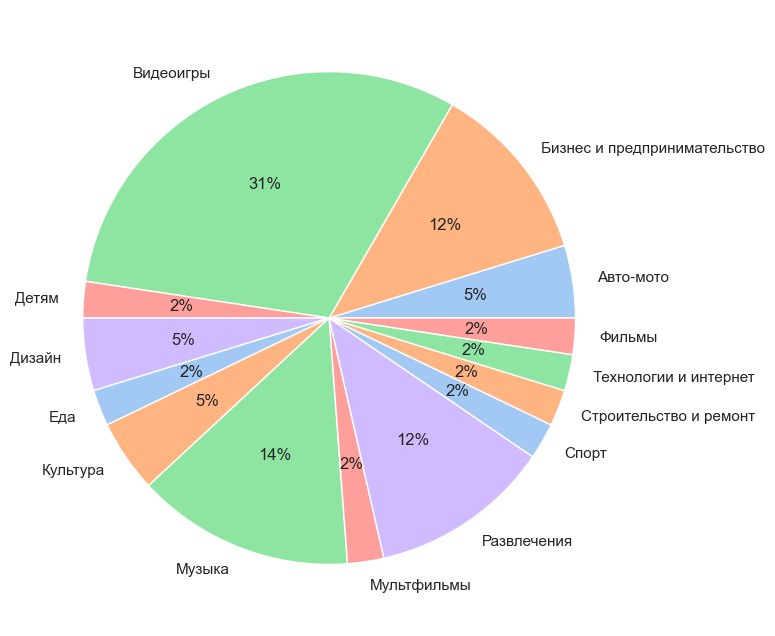

In [104]:
tmp_dt = video_stat[video_stat['item_id'].isin(logs_df[logs_df['user_id'] == user]['item_id'])][['item_id', 'title', 'category_id', 'description']]
sns.set(rc={'figure.figsize': (15, 8)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(tmp_dt['category_id'].unique())
dt = np.array([len(tmp_dt[tmp_dt['category_id'] == i])for i in labels])
plt.pie(dt, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

In [105]:
import json


json_req = {}
for i in video_stat[video_stat['item_id'].isin(recommendations['item_id'])][['item_id', 'title', 'category_id', 'description']].values:
    json_req[i[0]] = i[1:].tolist()


with open('json_req.json', 'w', encoding='utf-8') as js_r:
    json.dump(json_req, js_r, ensure_ascii=False, indent=4)

# save model and data base

In [107]:
import pickle

with open("PopularModel.pkl", "wb") as f:
    pickle.dump(model, f)


with open("ImplicitItemKNNWrapperModel.pkl", "wb") as f:
    pickle.dump(model_knn, f)


with open("PureSVDModel.pkl", "wb") as f:
    pickle.dump(model_svd, f)


with open("dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)

# conect with global data

In [108]:
logs_df

,datetime,user_id,item_id,weight
0,2024-08-05 12:12:32+03:00,bd1b6b07-e6a2-46ad-aa58-990bb7e89252,0af133e1-4fbf-4e10-b9e8-19fbe1a011c3,0
1,2024-08-05 18:30:15+03:00,7db026fc-b55c-4580-bc26-e3df59ba6c7c,4f42aab2-6238-4381-bb53-36213916e912,0
2,2024-08-05 12:35:16+03:00,5c94a654-f376-4529-b463-b62b6b50e8ca,8b106b84-f3f5-4c27-820c-7e1546b43614,0
3,2024-08-05 20:48:51+03:00,b972399a-c4b9-47fe-88fa-ccb1827cd131,305389f3-1c8d-4026-9eef-e2b875a35380,4
4,2024-08-05 05:19:19+03:00,807fb9e8-0aac-4dd2-836b-48797681f4ff,caeb71a4-f0f6-4c6a-ac79-31bdbb58fef1,1
...,...,...,...,...
29340328,2024-08-05 08:34:54+03:00,7f4f21b0-e155-4553-94f8-cafa0abe0917,c0432869-f7c3-4417-95c2-8c95e413994d,4
29340329,2024-08-05 09:42:57+03:00,39ae1273-470d-4a49-9802-3736fea3c64f,67d2ee4f-4309-415d-90b4-a9b7328067d1,0
29340330,2024-08-05 22:11:50+03:00,81d784b7-cda3-41d4-a648-f3d2d0749a3f,0051ec7f-1264-4f7c-8679-38b96c2c7bad,0
29340331,2024-08-05 14:06:42+03:00,8bd363cf-5115-449e-9ebf-e82f83d3db40,8cbfd763-c21b-4371-a1f2-3806eaa5ab8b,4


In [109]:
video_stat

,item_id,v_pub_datetime,v_total_comments,v_year_views,v_month_views,v_week_views,v_day_views,v_likes,v_dislikes,v_duration,...,v_frac_avg_watchtime_30_day_duration,v_category_popularity_percent_7_days,v_category_popularity_percent_30_days,v_long_views_1_days,v_long_views_7_days,v_long_views_30_days,title,description,category_id,author_id
0,973f24c0-15b2-434f-8740-4e2726f79c30,2024-06-15 22:58:03+03:00,0.0,556.0,2.0,0.0,0.0,0.0,0.0,7.733000,...,0.000000,1.656250,1.617188,0.0,0.0,0.0,пережила свой яд,,Мультфильмы,79276150-fdaf-4626-9452-6f1ad975741d
1,1a3f527c-44b2-4f7e-9641-26f078edbf2e,2021-04-18 17:27:42+03:00,0.0,109.0,2.0,1.0,0.0,0.0,0.0,379.000000,...,0.106860,5.570312,5.648438,0.0,0.0,0.0,"🎓Знаете ли Вы, что ؟ Интересные факты ! # ...","🎓Знаете ли Вы, что ? Интересные факты ! # 2🎓...",Развлечения,16278647-5912-48af-a071-582dcfd0e354
2,2f563d09-45ef-4e27-8da0-daa74235a2e7,2022-11-17 16:36:43+03:00,0.0,163.0,2.0,2.0,0.0,0.0,0.0,1020.767029,...,0.156745,0.342529,0.285400,0.0,0.0,0.0,"ЗИМНЯЯ, ТЕПЛАЯ ШЛЯПА крючком. Как связать поля...",Шляпа связана из пряжи NAKO Sport Wool в 100гр...,Хобби,9afa94aa-c2a6-43fc-a0d1-175eaf7fa194
3,154fac0e-1794-4406-afa0-61f688e3a764,2010-01-01 00:00:01+03:00,0.0,10657.0,5227.0,1300.0,202.0,24.0,0.0,42.025002,...,2.909949,0.418457,0.513672,186.0,1162.0,4550.0,найк,найк дрессура,Животные,4af9b043-40f4-4288-85c6-192612dca35b
4,470b4e3e-e06d-4370-80dc-34d6a78b22db,2023-11-29 16:49:46+03:00,0.0,154.0,45.0,13.0,1.0,0.0,0.0,695.646973,...,0.257155,9.312500,9.289062,0.0,8.0,18.0,SHACMAN. Шакман замена двухрядного подшипника ...,,Разное,841e6bd8-0015-4502-a3e9-aaa07112a585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555682,6e3067be-8602-4889-b296-3dbba9e29a14,2023-07-22 17:48:30+03:00,0.0,705.0,39.0,23.0,7.0,0.0,0.0,92.996002,...,0.171223,10.703125,12.765625,0.0,5.0,5.0,Сергий против нечисти сериал / сергий против н...,сергий против нечисти смотреть\t сергий против...,Сериалы,3d4ea198-d327-4e21-af62-3e93fcd69e08
1555683,542bb668-c8ec-4047-80c6-d98b39d3b7ce,2010-06-17 18:38:04+03:00,0.0,109.0,2.0,0.0,0.0,0.0,0.0,65.279999,...,0.934436,1.446289,1.454102,0.0,0.0,2.0,Greece 2-1 Nigeria,,Спорт,69573325-e993-43f4-accd-1ddb5252859d
1555684,eeeb7b1e-6e46-4633-a9fb-3782256857f5,2022-11-06 09:24:55+03:00,0.0,162.0,20.0,4.0,2.0,0.0,0.0,94.134003,...,0.422802,8.953125,9.296875,0.0,0.0,9.0,Сказочный патруль когда выйдут 76-77 серии тео...,,Лайфстайл,307f2310-337d-4065-990d-37635286908f
1555685,7ef043b7-a34c-40c7-865e-1b251b00df72,2023-11-17 01:35:34+03:00,0.0,144.0,22.0,9.0,2.0,0.0,0.0,321.829010,...,0.299001,5.488281,3.679688,0.0,2.0,8.0,Гайд на 120 фпс // Разблокировка Фпс после 9.2...,#120fps #120fps_blitz 0:19 Предыстория 1:27 За...,Разное,f8daacc1-aa63-4721-94b8-153a6913df37
